# Training a neural network with McSnow selfcollection output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'
fname1=mdir+edir+'autocon_train_small.nc'
fname2=mdir+edir+'autocon_test_small.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 5, ii: 5, j: 5, jj: 5, k: 3, kk: 3, n: 2, nn: 2, nt: 4000)
Coordinates:
  * n           (n) int32 0 1
  * i           (i) int32 400 600 800 1000 2000
  * j           (j) int32 11 12 13 14 15
  * k           (k) int32 0 1 2
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n, i, j, k, nt) floa

# Prepare data for training

In [4]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    self = xr.open_dataset(fname).self_cloud.values
    Lc   = xr.open_dataset(fname).Lc.values
    Nc   = xr.open_dataset(fname).Nc.values
    nu   = xr.open_dataset(fname).nu.values  # this is nu0, nue is the time-dependent shape
    tau  = xr.open_dataset(fname).tau.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    self_min = 7e-10
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    self = np.log(self, where=self>self_min, out=np.nan*self)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ self.ravel(), Lc.ravel(), Nc.ravel(), Xc.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = [ 'self','Lc','Nc','Xc','nu','tau' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


### Inspect the data

In [6]:
dataset_train.describe()

self            Lc            Nc            Xc            nu  \
count  30124.000000  30124.000000  30124.000000  30124.000000  30124.000000   
mean       4.903029     -9.050030     16.618214    -25.668030      1.067322   
std        4.567624      2.133616      1.864130      0.541698      0.809774   
min      -10.983475    -14.732396     10.919631    -28.129522      0.000000   
25%        1.844342    -10.709814     15.139380    -25.883636      0.000000   
50%        6.977389     -7.941823     17.310427    -25.609933      1.000000   
75%        8.231452     -7.423662     18.038115    -25.329503      2.000000   
max       11.281706     -6.216034     19.690811    -24.881920      2.000000   

                tau  
count  30124.000000  
mean      -3.719634  
std        5.561783  
min      -30.567400  
25%       -5.367156  
50%       -1.041131  
75%       -0.035101  
max       -0.001001

In [7]:
dataset_test.describe()

self            Lc            Nc            Xc            nu  \
count  11587.000000  11587.000000  11587.000000  11587.000000  11587.000000   
mean       4.993925     -9.012414     16.667330    -25.679798      1.067144   
std        4.637621      2.175892      1.894260      0.548470      0.808479   
min      -12.844731    -14.509624     11.200713    -28.135550      0.000000   
25%        1.738340    -10.763694     15.112677    -25.889509      0.000000   
50%        7.346133     -7.809584     17.432096    -25.615314      1.000000   
75%        8.407926     -7.283112     18.168568    -25.333506      2.000000   
max       10.711625     -6.503711     19.401567    -24.882051      2.000000   

                tau  
count  11587.000000  
mean      -3.709986  
std        5.626854  
min      -30.287693  
25%       -5.318472  
50%       -0.964276  
75%       -0.029841  
max       -0.001002

### Reduce the data

In [8]:
def reduce_data(dataset):
    idx = dataset[ dataset['Lc'] < np.log(1e-7) ].index
    dataset.drop(idx,inplace=True)
    idx = dataset[ dataset['tau'] > np.log(0.95) ].index
    dataset.drop(idx,inplace=True)
    return dataset

In [9]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

In [10]:
dataset_train.describe()

self            Lc            Nc            Xc            nu  \
count  21751.000000  21751.000000  21751.000000  21751.000000  21751.000000   
mean       7.375956     -7.878761     17.604429    -25.483128      1.103352   
std        1.885894      0.946180      0.962882      0.342776      0.803966   
min       -2.972467    -10.821355     14.212520    -26.510252      0.000000   
25%        6.667623     -8.179891     17.121206    -25.825610      0.000000   
50%        7.701431     -7.825642     17.766058    -25.564100      1.000000   
75%        8.592096     -7.217290     18.224901    -25.168531      2.000000   
max       11.281706     -6.216034     19.690811    -24.881920      2.000000   

                tau  
count  21751.000000  
mean      -5.146283  
std        5.959808  
min      -30.567400  
25%       -7.342706  
50%       -3.085961  
75%       -0.644157  
max       -0.051293

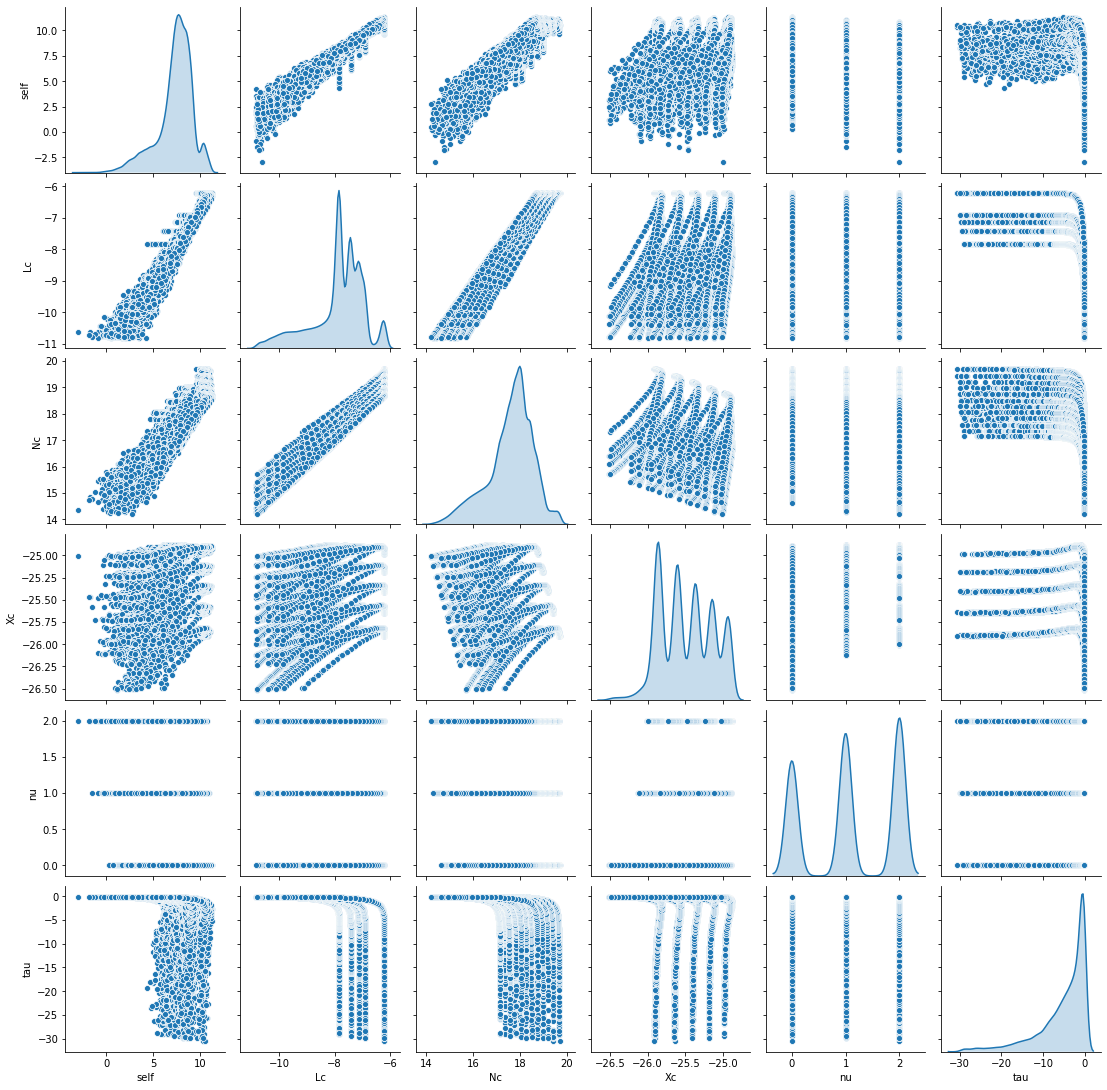

In [11]:
sns.pairplot(dataset_train[['self','Lc','Nc','Xc','nu','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [12]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

In [13]:
train_dataset0 = train_dataset0.drop(['Xc','nu','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Nc','nu','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['Xc','tau'], axis=1)
train_dataset3 = train_dataset3.drop(['Nc','tau'], axis=1)
train_dataset4 = train_dataset4.drop(['Nc'], axis=1)

In [14]:
test_dataset0 = test_dataset0.drop(['Xc','nu','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Nc','nu','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['Xc','tau'], axis=1)
test_dataset3 = test_dataset3.drop(['Nc','tau'], axis=1)
test_dataset4 = test_dataset4.drop(['Nc'], axis=1)

In [15]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("self")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%        50%        75%  \
Lc  21751.0  -7.878761  0.946180 -10.821355  -8.179891  -7.825642  -7.217290   
Nc  21751.0  17.604429  0.962882  14.212520  17.121206  17.766058  18.224901   

          max  
Lc  -6.216034  
Nc  19.690811

In [16]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  21751.0  -7.878761  0.946180 -10.821355  -8.179891  -7.825642  -7.217290   
Xc  21751.0 -25.483128  0.342776 -26.510252 -25.825610 -25.564100 -25.168531   

          max  
Lc  -6.216034  
Xc -24.881920

In [17]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  21751.0  -7.878761  0.946180 -10.821355  -8.179891  -7.825642  -7.217290   
Nc  21751.0  17.604429  0.962882  14.212520  17.121206  17.766058  18.224901   
nu  21751.0   1.103352  0.803966   0.000000   0.000000   1.000000   2.000000   

          max  
Lc  -6.216034  
Nc  19.690811  
nu   2.000000

In [18]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lc  21751.0  -7.878761  0.946180 -10.821355  -8.179891  -7.825642  -7.217290   
Xc  21751.0 -25.483128  0.342776 -26.510252 -25.825610 -25.564100 -25.168531   
nu  21751.0   1.103352  0.803966   0.000000   0.000000   1.000000   2.000000   

          max  
Lc  -6.216034  
Xc -24.881920  
nu   2.000000

In [19]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("self")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%        75%  \
Lc   21751.0  -7.878761  0.946180 -10.821355  -8.179891  -7.825642  -7.217290   
Xc   21751.0 -25.483128  0.342776 -26.510252 -25.825610 -25.564100 -25.168531   
nu   21751.0   1.103352  0.803966   0.000000   0.000000   1.000000   2.000000   
tau  21751.0  -5.146283  5.959808 -30.567400  -7.342706  -3.085961  -0.644157   

           max  
Lc   -6.216034  
Xc  -24.881920  
nu    2.000000  
tau  -0.051293

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [20]:
train_labels0 = train_dataset0.pop('self')
train_labels1 = train_dataset1.pop('self')
train_labels2 = train_dataset2.pop('self')
train_labels3 = train_dataset3.pop('self')
train_labels4 = train_dataset4.pop('self')

test_labels0  = test_dataset0.pop('self')
test_labels1  = test_dataset1.pop('self')
test_labels2  = test_dataset2.pop('self')
test_labels3  = test_dataset3.pop('self')
test_labels4  = test_dataset4.pop('self')

### Normalize the data

In [21]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [22]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  21751.0  0.000019  1.000001 -3.109973 -0.318259  0.056141  0.699097   
Nc  21751.0 -0.000029  1.000000 -3.522665 -0.501851  0.167859  0.644391   

         max  
Lc  1.757306  
Nc  2.166810

In [23]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lc  21751.0  0.000019  1.000001 -3.109973 -0.318259  0.056141  0.699097   
Xc  21751.0 -0.000050  1.000002 -2.996487 -0.999144 -0.236226  0.917789   

         max  
Lc  1.757306  
Xc  1.753937

In [24]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean       std       min       25%       50%       75%  \
Lc  21751.0  1.893003e-05  1.000001 -3.109973 -0.318259  0.056141  0.699097   
Nc  21751.0 -2.889691e-05  1.000000 -3.522665 -0.501851  0.167859  0.644391   
nu  21751.0 -2.857687e-08  0.999976 -1.372387 -1.372387 -0.128552  1.115282   

         max  
Lc  1.757306  
Nc  2.166810  
nu  1.115282

In [25]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc  21751.0  1.893003e-05  1.000001 -3.109973 -0.318259  0.056141  0.699097   
Xc  21751.0 -5.019409e-05  1.000002 -2.996487 -0.999144 -0.236226  0.917789   
nu  21751.0 -2.857687e-08  0.999976 -1.372387 -1.372387 -0.128552  1.115282   

         max  
Lc  1.757306  
Xc  1.753937  
nu  1.115282

In [26]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean       std       min       25%       50%       75%  \
Lc   21751.0  1.893003e-05  1.000001 -3.109973 -0.318259  0.056141  0.699097   
Xc   21751.0 -5.019409e-05  1.000002 -2.996487 -0.999144 -0.236226  0.917789   
nu   21751.0 -2.857687e-08  0.999976 -1.372387 -1.372387 -0.128552  1.115282   
tau  21751.0  1.346321e-06  1.000002 -4.265425 -0.368539  0.345703  0.755414   

          max  
Lc   1.757306  
Xc   1.753937  
nu   1.115282  
tau  0.854891

# The model

## Build the model

In [27]:
def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [28]:

#activ = "PReLU"
#activ = "LReLU"
activ = "tanh"
#activ = "ReLU"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [30]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.50274384],
       [-0.5020921 ],
       [-0.50178474],
       [-0.5012912 ],
       [-0.50100267],
       [-0.5006778 ],
       [-0.50041443],
       [-0.4996892 ],
       [-0.4991603 ],
       [-0.498364  ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [31]:
# maximum number, but we use early stopping
EPOCHS = 1000

# part of training data that is used for validation during training
VALSPLIT = 0.2

# learning rate
learn = 1e-4        # original value was 1e-3

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [32]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:46.8243,  mae:6.7098,  mse:46.8243,  val_loss:45.8358,  val_mae:6.7249,  val_mse:45.8358,  
............................................

Text(0, 0.5, 'MAE')

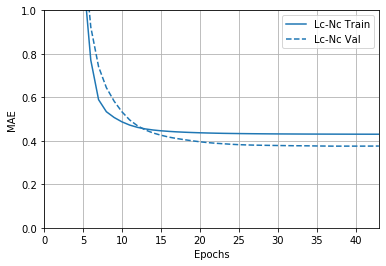

In [33]:
histories['Lc-Nc'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [34]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:48.5288,  mae:6.7632,  mse:48.5288,  val_loss:51.5711,  val_mae:7.0886,  val_mse:51.5711,  
..........................................................

Text(0, 0.5, 'MAE')

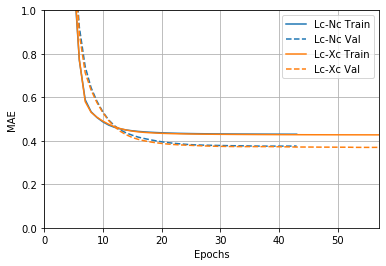

In [35]:
histories['Lc-Xc'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [36]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:46.4658,  mae:6.6623,  mse:46.4658,  val_loss:45.4168,  val_mae:6.6784,  val_mse:45.4168,  
.......................................................................................

Text(0, 0.5, 'MAE')

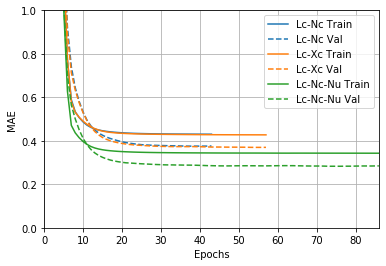

In [37]:
histories['Lc-Nc-nu'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [38]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:48.2085,  mae:6.6930,  mse:48.2085,  val_loss:52.3585,  val_mae:7.1077,  val_mse:52.3585,  
.....................................................

Text(0, 0.5, 'MAE')

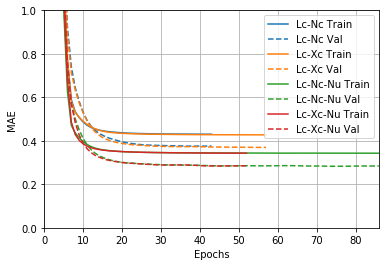

In [39]:
histories['Lc-Xc-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [40]:
model4 = build_model(len(normed_train_data4.keys()),activ,learn)

# maximum number, but we use early stopping
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:48.4207,  mae:6.7488,  mse:48.4207,  val_loss:53.5291,  val_mae:7.2012,  val_mse:53.5291,  
....................................................................................................
Epoch: 100, loss:0.1722,  mae:0.2926,  mse:0.1722,  val_loss:0.0749,  val_mae:0.1953,  val_mse:0.0749,  
.........................

Text(0, 0.5, 'MAE of AU')

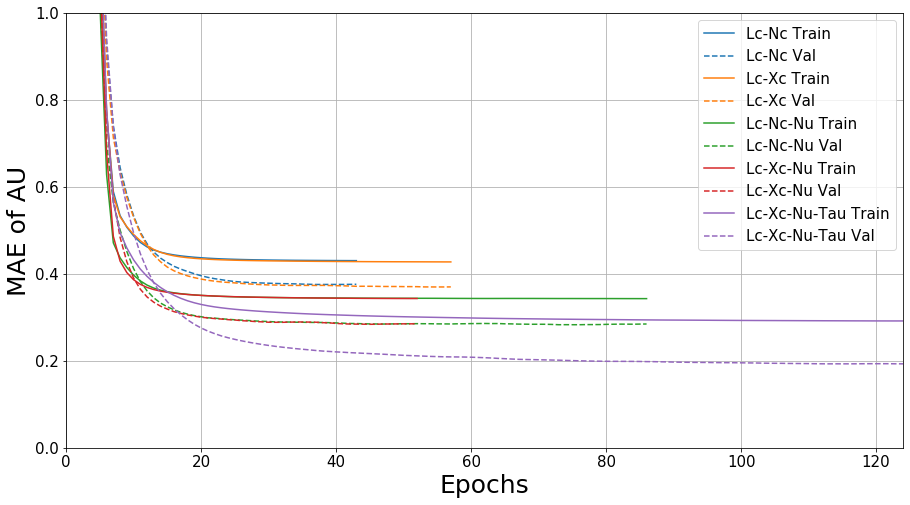

In [71]:
histories['Lc-Xc-nu-tau'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE of AU')

Text(0, 0.5, 'MSE of AU')

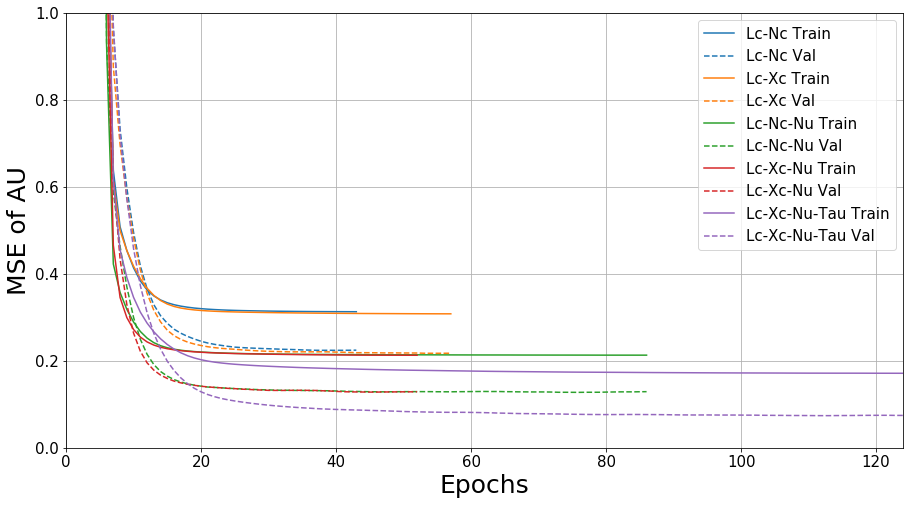

In [69]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 1])
plt.ylabel('MSE of AU')

In [43]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

8234/8234 - 0s - loss: 0.2525 - mae: 0.3963 - mse: 0.2525
Testing set for model 0, Mean Abs Error:    0.39630


In [44]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

8234/8234 - 0s - loss: 0.2433 - mae: 0.3880 - mse: 0.2433
Testing set for model 1, Mean Abs Error:    0.38795


In [45]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

8234/8234 - 0s - loss: 0.1576 - mae: 0.3041 - mse: 0.1576
Testing set for model 2, Mean Abs Error:    0.30406


In [46]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

8234/8234 - 0s - loss: 0.1564 - mae: 0.3023 - mse: 0.1564
Testing set for model 3, Mean Abs Error:    0.30230


In [47]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

8234/8234 - 0s - loss: 0.1120 - mae: 0.2372 - mse: 0.1120
Testing set for model 4, Mean Abs Error:    0.23717


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

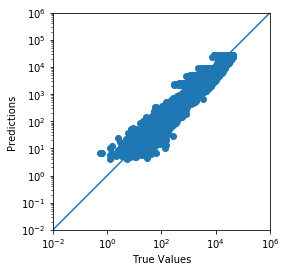

In [48]:
test_self0 = np.exp(test_labels0)
test_self1 = np.exp(test_labels1)
test_self2 = np.exp(test_labels2)
test_self3 = np.exp(test_labels3)
test_self4 = np.exp(test_labels4)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-2, 1e6

a = plt.axes(aspect='equal')
plt.scatter(test_self0, test_predict0)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

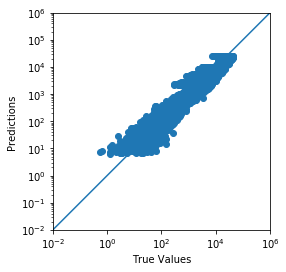

In [49]:
a = plt.axes(aspect='equal')
plt.scatter(test_self1, test_predict1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

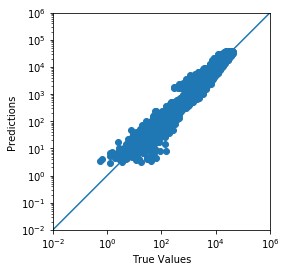

In [50]:
a = plt.axes(aspect='equal')
plt.scatter(test_self2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

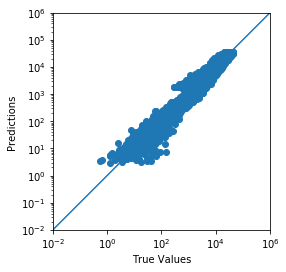

In [51]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_self3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

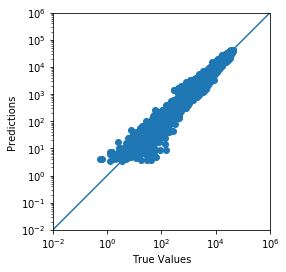

In [52]:
test_predict4 = np.exp(model4.predict(normed_test_data4).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_self4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [53]:
test_dataset2.describe()

Lc           Nc          nu
count  8234.000000  8234.000000  8234.00000
mean     -7.767566    17.717304     1.10651
std       0.901596     0.919605     0.80350
min     -10.598797    14.462896     0.00000
25%      -8.034768    17.294874     0.00000
50%      -7.602831    17.905163     1.00000
75%      -7.265977    18.330225     2.00000
max      -6.503711    19.401567     2.00000

## SB2001 autoconversion rate, original and re-trained on current data

In [54]:
kcr = 5.78       # Long kernel in m3 kg-1 s-1 
kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 

qc  = np.exp(np.array(test_dataset2.Lc))
nc  = np.exp(np.array(test_dataset2.Nc))
nue = np.array(test_dataset2.nu)

selfSB = kcc * (nue+2)/(nue+1) * qc*qc

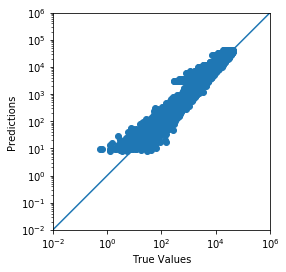

In [55]:
test_predict_sb = selfSB

a = plt.axes(aspect='equal')
plt.scatter(test_self4, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Final statistics 

In [56]:
self0 = test_predict0
self1 = test_predict1
self2 = test_predict2
self3 = test_predict3
self4 = test_predict4

selfTruth = test_self4

In [57]:
np.max(selfTruth)

44874.50390625

In [58]:
def mean_abs_error(var, varTrue):  
    return np.mean(np.abs(var - varTrue))

def mean_sqr_error(var, varTrue):    
    return np.sqrt(np.mean((var - varTrue)**2))                   

In [59]:
mae0 = mean_abs_error(self0,test_self0)
mae1 = mean_abs_error(self1,test_self1)
mae2 = mean_abs_error(self2,test_self2)
mae3 = mean_abs_error(self3,test_self3)
mae4 = mean_abs_error(self4,test_self4)
maeSB = mean_abs_error(selfSB,selfTruth)
#maeKK  = mean_abs_error(selfKK,selfTruth)
#maePwr = mean_abs_error(selfPwr,selfTruth)

mse0 = mean_sqr_error(self0,test_self0)
mse1 = mean_sqr_error(self1,test_self1)
mse2 = mean_sqr_error(self2,test_self2)
mse3 = mean_sqr_error(self3,test_self3)
mse4 = mean_sqr_error(self4,test_self4)
mseSB = mean_sqr_error(selfSB,selfTruth)
#mseSB2 = mean_sqr_error(selfSB2,selfTruth)
#mseKK  = mean_sqr_error(selfKK,selfTruth)
#msePwr = mean_sqr_error(selfPwr,selfTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB ] #, mseSB2, mseKK, msePwr ]

In [60]:
mae

[1665.5804443359375,
 1646.056396484375,
 1198.83447265625,
 1182.60205078125,
 754.7059936523438,
 2038.9779052734375]

In [61]:
labels = list(histories.keys())
labels.append('SB2001')
labels

['Lc-Nc', 'Lc-Xc', 'Lc-Nc-nu', 'Lc-Xc-nu', 'Lc-Xc-nu-tau', 'SB2001']

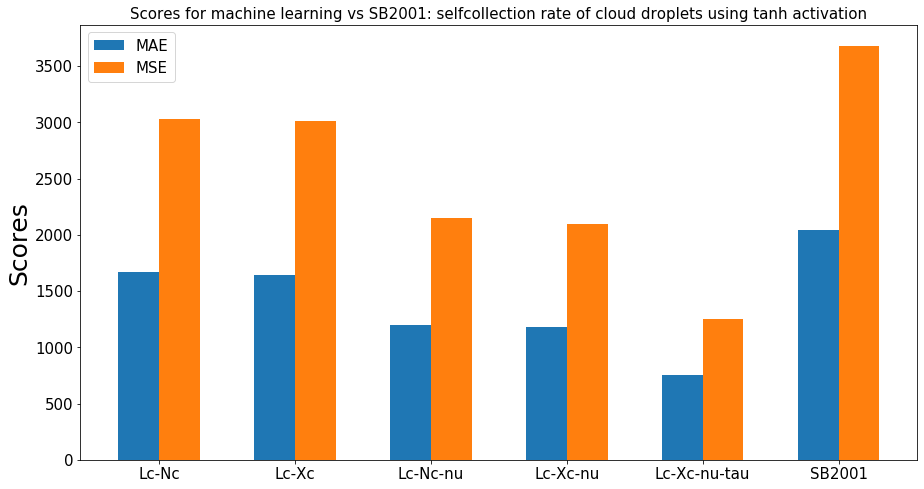

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (15,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: selfcollection rate of cloud droplets using '+activ+' activation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()



# Save models and normalization

In [63]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model0.save('saved_model/selfcloud_v4_LcNc_'+activ+'_16x16x16') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/selfcloud_v4_LcNc_tanh_16x16x16/assets


In [64]:
model1.save('saved_model/selfcloud_v4_LcXc_'+activ+'_16x16x16') 

INFO:tensorflow:Assets written to: saved_model/selfcloud_v4_LcXc_tanh_16x16x16/assets


In [65]:
model2.save('saved_model/selfcloud_v4_LcNcNu_'+activ+'_16x16x16') 

INFO:tensorflow:Assets written to: saved_model/selfcloud_v4_LcNcNu_tanh_16x16x16/assets


In [66]:
model3.save('saved_model/selfcloud_v4_LcXcNu_'+activ+'_16x16x16') 

INFO:tensorflow:Assets written to: saved_model/selfcloud_v4_LcXcNu_tanh_16x16x16/assets


In [67]:
model4.save('saved_model/selfcloud_v4_LcXcNuTau_'+activ+'_16x16x16') 

INFO:tensorflow:Assets written to: saved_model/selfcloud_v4_LcXcNuTau_tanh_16x16x16/assets


In [68]:
# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model/selfcloud_v4_LcNc_'+activ+'_16x16x16'+'_norm.pickle')
train_stats1.to_pickle('saved_model/selfcloud_v4_LcXc_'+activ+'_16x16x16'+'_norm.pickle')
train_stats2.to_pickle('saved_model/selfcloud_v4_LcNcNu_'+activ+'_16x16x16'+'_norm.pickle')
train_stats3.to_pickle('saved_model/selfcloud_v4_LcXcNu_'+activ+'_16x16x16'+'_norm.pickle')
train_stats4.to_pickle('saved_model/selfcloud_v4_LcXcNuTau_'+activ+'_16x16x16'+'_norm.pickle')